In [4]:
#import modules
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from data import SQLRepository
from arch import arch_model

In [5]:
#open connection to database
connection = sqlite3.connect(database=os.getenv('DB_NAME'), check_same_thread=False)
#instantiate sqlrepository from data module
repo = SQLRepository(connection=connection, ticker='MSFT')

In [7]:
#pull out 'msft' data from database with only 2500 rows
df_microsoft = repo.read_table(table_name='MSFT', limit=2500)
print('microsoft data info: ', df_microsoft.info())
df_microsoft.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2023-09-01 to 2013-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
dtypes: float64(5)
memory usage: 117.2 KB
microsoft data info:  None


,open,high,low,close,volume
date,,,,,
2023-09-01,331.31000,331.98999,326.78000,328.66000,11731168.0
2023-08-31,329.20001,330.91000,326.78000,327.76001,26389000.0
2023-08-30,328.67001,329.81000,326.45001,328.79001,15222100.0
2023-08-29,321.88000,328.98001,321.88000,328.41000,19284600.0
2023-08-28,325.66000,326.14999,321.72000,323.70001,14808500.0


In [8]:
def wrangle(ticker, n_observations):
    #get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations)
    #create returns column
    df['return'] = df['close'].pct_change()*100
    #set in ascending order
    df.sort_values(by='date', inplace=True)
    #ffill 'nan' values
    df.fillna(method='ffill', inplace=True)
    #create series with only 'returns' column
    returns = df['return']
    return returns

In [9]:
y_microsoft = wrangle(ticker="MSFT", n_observations=2500)

# Is `y_microsoft` a Series?
assert isinstance(y_microsoft, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_microsoft) == 2500

# Is `y_microsoft` name "return"?
assert y_microsoft.name == "return"

# Does `y_microsoft` have a DatetimeIndex?
assert isinstance(y_microsoft.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_microsoft.index == y_microsoft.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_microsoft.isnull().sum() == 0

y_microsoft.head()

date
2013-09-30   -0.893389
2013-10-01   -1.002358
2013-10-02    0.177200
2013-10-03   -0.059032
2013-10-04    1.741742
Name: return, dtype: float64

In [10]:
#get data for apple stocks
y_apple = wrangle(ticker='AAPL', n_observations=2500)

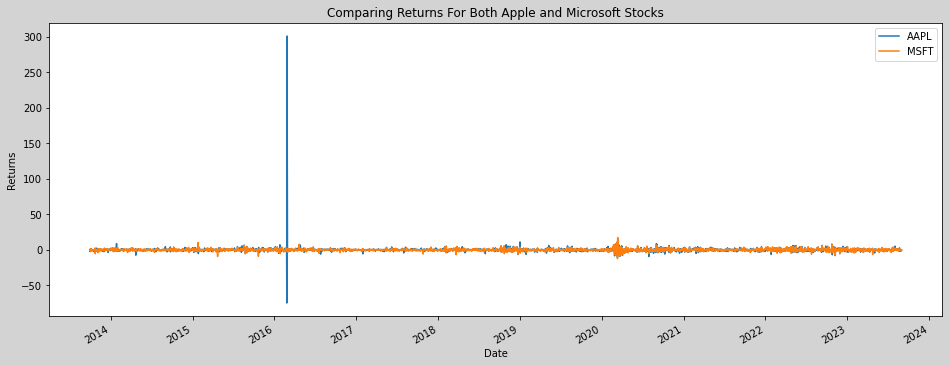

In [11]:
#make a lineplot for stock returns for both apple and microsoft
fig, ax = plt.subplots(figsize=(16,6), facecolor='lightgray')
y_apple.plot(ax=ax, label='AAPL')
y_microsoft.plot(ax=ax, label='MSFT')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Comparing Returns For Both Apple and Microsoft Stocks')
plt.legend()
plt.show();

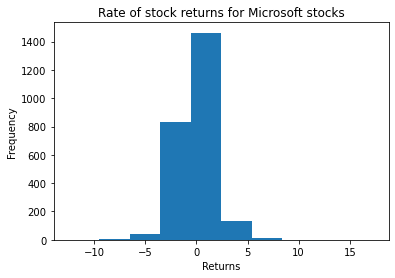

In [12]:
y_microsoft.plot.hist(bins=10)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Rate of stock returns for Microsoft stocks')
plt.show();

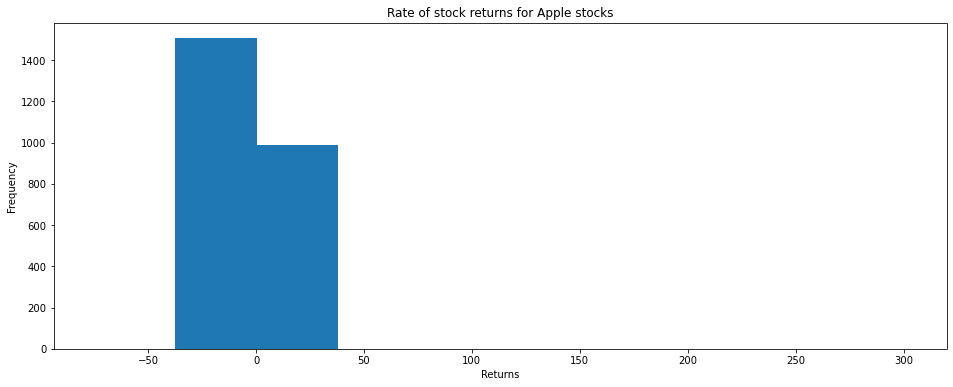

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
y_apple.plot.hist(ax=ax)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Rate of stock returns for Apple stocks')
plt.show();

In [14]:
y_apple.idxmin(), y_apple.min()

(Timestamp('2016-02-26 00:00:00'), -75.00773594636411)

In [15]:
#calculate daily volatility for 'apple' and 'microsoft' stocks
apple_daily_volatility = y_apple.std()
microsoft_daily_volatility = y_microsoft.std()
print('Daily volatility for apple stocks: ', apple_daily_volatility)
print('Daily volatility for microsoft stocks: ', microsoft_daily_volatility)

Daily volatility for apple stocks:  6.462989563485596
Daily volatility for microsoft stocks:  1.710350704956456


In [16]:
#calculate annual volatility for 'apple' and 'microsoft' stocks
apple_annual_volatility = (y_apple.std()) * np.sqrt(252)
microsoft_annual_volatility = y_microsoft.std() * np.sqrt(252)
print('annual volatility for apple stocks: ', apple_annual_volatility)
print('annual volatility for microsoft stocks: ', microsoft_annual_volatility)

annual volatility for apple stocks:  102.5967786659327
annual volatility for microsoft stocks:  27.15097572011274


In [17]:
#get 50d rolling volatility for both apple and microsoft stocks
apple_50d_rolling = y_apple.rolling(window=50).std()
microsoft_50d_rolling = y_microsoft.rolling(window=50).std()

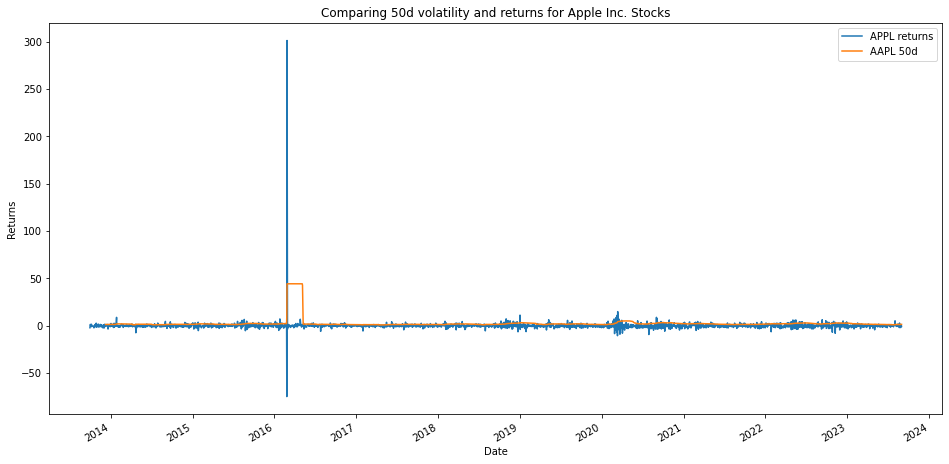

In [18]:
#plot 50d rolling volatility and returns for apple stocks
fig,ax = plt.subplots(figsize=(16,8))
y_apple.plot(ax=ax, label='APPL returns')
apple_50d_rolling.plot(ax=ax, label='AAPL 50d')
plt.title('Comparing 50d volatility and returns for Apple Inc. Stocks')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show();

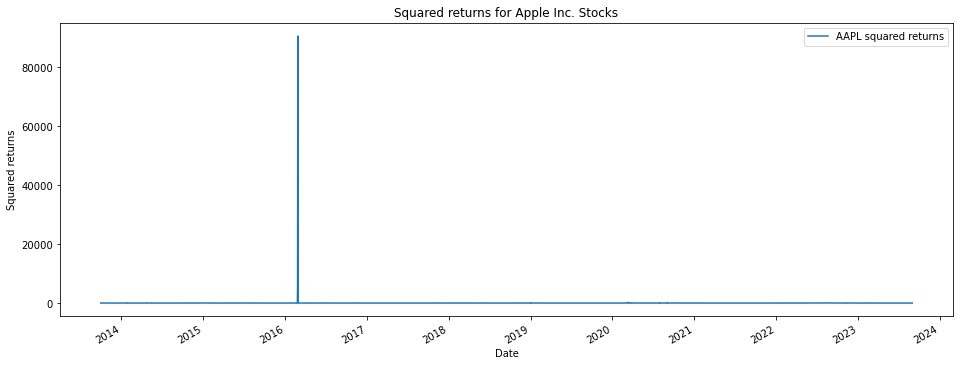

In [19]:
#plot 50d volatility and squared returns for apple inc. stocks
fig, ax = plt.subplots(figsize=(16,6))
(y_apple**2).plot(ax=ax, label='AAPL squared returns')
plt.title('Squared returns for Apple Inc. Stocks')
plt.xlabel('Date')
plt.ylabel('Squared returns')
plt.legend()
plt.show();

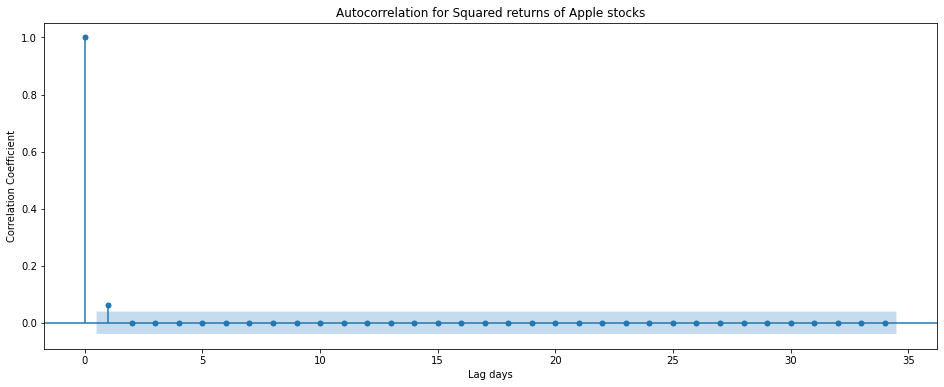

In [20]:
fig, ax = plt.subplots(figsize=(16,6))
#plot acf of squared returns
plot_acf(y_apple**2, ax=ax)
plt.xlabel('Lag days')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation for Squared returns of Apple stocks')
plt.show();

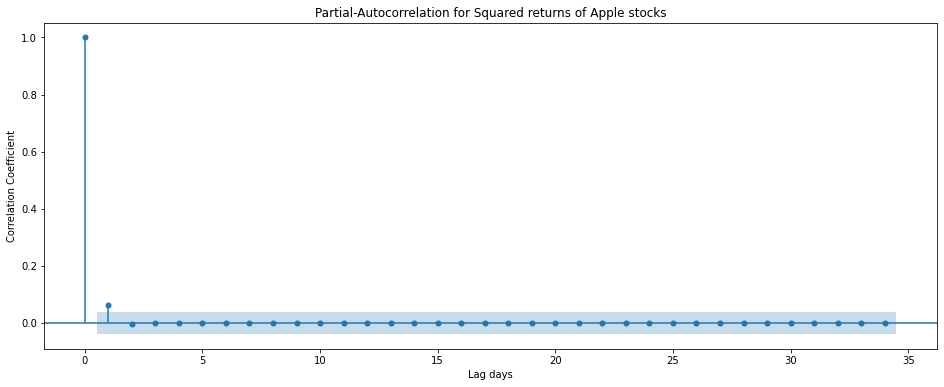

In [21]:
fig, ax = plt.subplots(figsize=(16,6))
#plot pacf of squared returns
plot_pacf(y_apple**2, ax=ax)
plt.xlabel('Lag days')
plt.ylabel('Correlation Coefficient')
plt.title('Partial-Autocorrelation for Squared returns of Apple stocks')
plt.show();

In [22]:
#split data
cutoff_test = int(len(y_apple)*0.80)
y_apple_train = y_apple.iloc[:cutoff_test]
print("y_apple_train type:", type(y_apple_train))
print("y_apple_train shape:", y_apple_train.shape)
y_apple_train.tail()

y_apple_train type: <class 'pandas.core.series.Series'>
y_apple_train shape: (2000,)


date
2021-08-31   -0.445866
2021-09-01   -0.741946
2021-09-02   -0.421264
2021-09-03   -1.525305
2021-09-07    1.018632
Name: return, dtype: float64

In [23]:
#build model
model = arch_model(y_apple_train, p=1, q=1, rescale=False).fit(disp=0)
#print model type
print('model type: ', type(model))
#get model summary
model.summary()

model type:  <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4674.38
Distribution:                  Normal   AIC:                           9356.77
Method:            Maximum Likelihood   BIC:                           9379.17
                                        No. Observations:                 2000
Date:                Thu, Sep 14 2023   Df Residuals:                     1999
Time:                        16:21:44   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1479  4.629e-02     -3.194  1.403e-03 [ -0.239,-5.713e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          5.6599      3.067      1.846  6.494e-02      [ -0.350, 11.670]
alpha[1]       0.2331      0.108      2.161  3.072e-02    [2.165e-02,  0.445]
beta[1]        0.0000  4.517e-04      0.000      1.000 [-8.853e-04,8.853e-04]
=============================================================================

Covariance estimator: robust
"""

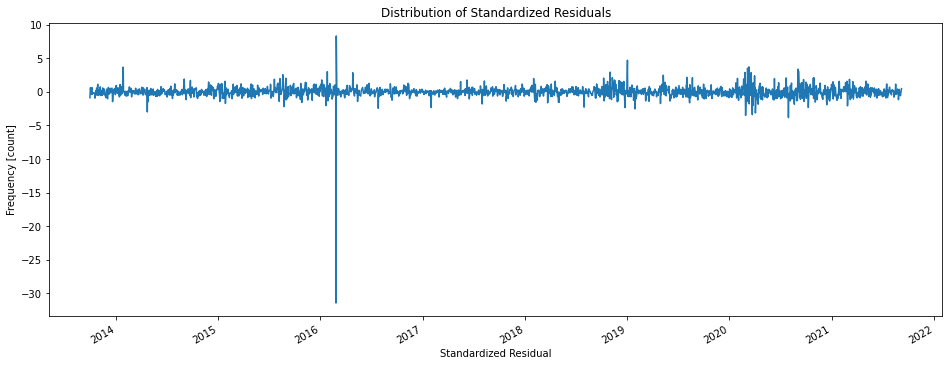

In [24]:
#plot standardaized rediduals
fig,ax = plt.subplots(figsize=(16,6))
model.std_resid.plot(ax=ax, label='Standardized residuals')
# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals");

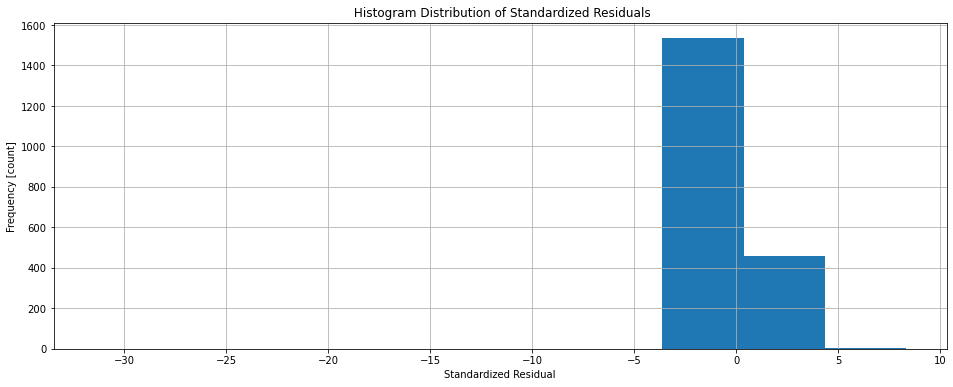

In [25]:
#check the distribution of standardized residuals
fig,ax = plt.subplots(figsize=(16,6))
model.std_resid.hist()
# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency [count]")

# Add title
plt.title(" Histogram Distribution of Standardized Residuals")
plt.show();

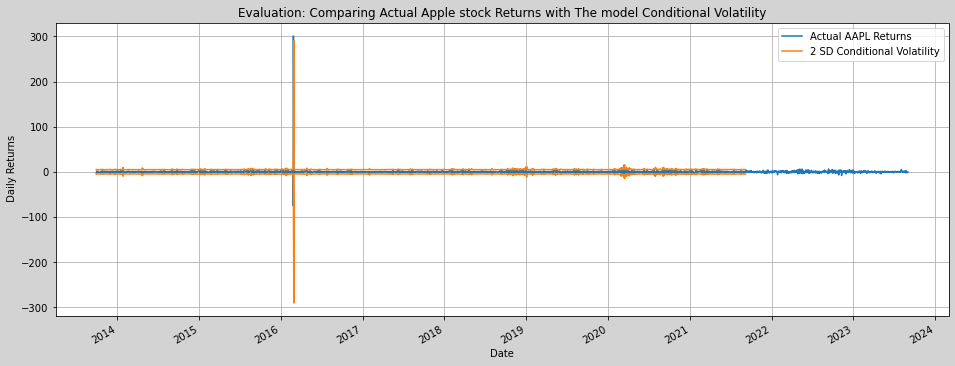

In [26]:
#model evaluation
fig,ax = plt.subplots(figsize=(16,6), facecolor='lightgray')
#actual returns
y_apple.plot(ax=ax, label='Actual AAPL Returns')
#conditional volatility
(2 * model.conditional_volatility).plot(ax=ax, color='C1', label='2 SD Conditional Volatility')
(-2 * model.conditional_volatility.rename("")).plot(ax=ax, color='C1')
plt.xlabel('Date')
plt.ylabel(' Daily Returns')
plt.title('Evaluation: Comparing Actual Apple stock Returns with The model Conditional Volatility')
plt.legend()
plt.grid()
plt.show();

In [27]:
#model iteration on test set
predictions = []
#calculate test size
test_size = int(len(y_apple)*0.2)
#perform walkforward
for i in range(test_size):
    test_set = y_apple.iloc[: -(test_size-i)]
    #train model
    model = arch_model(test_set, p=1, q=1, rescale=False).fit(disp=0)
    #generate next prediction
    next_pred = model.forecast(horizon=1, reindex=False).variance.values[0][0]**0.5
    #append predictions to list
    predictions.append(next_pred)
#create series from prediction list
wf_predictions = pd.Series(predictions, index=y_apple.tail(test_size).index)
print("wf type:", type(wf_predictions))
print("wf shape:", wf_predictions.shape)
wf_predictions.head()

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


wf type: <class 'pandas.core.series.Series'>
wf shape: (500,)


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


date
2021-09-08    2.444808
2021-09-09    2.411412
2021-09-10    2.937528
2021-09-13    2.381665
2021-09-14    2.437873
dtype: float64

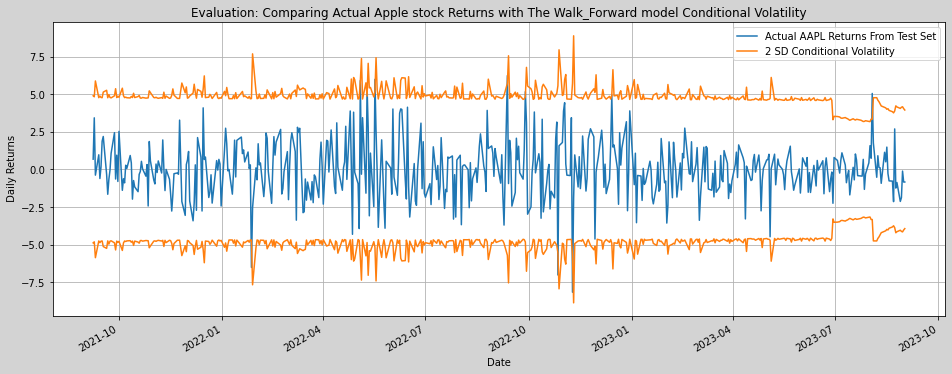

In [28]:
#model evaluation
fig,ax = plt.subplots(figsize=(16,6), facecolor='lightgray')
#actual returns
y_apple.tail(test_size).plot(ax=ax, label='Actual AAPL Returns From Test Set')
#conditional volatility
(2 * wf_predictions).plot(ax=ax, color='C1', label='2 SD Conditional Volatility')
(-2 * wf_predictions.rename("")).plot(ax=ax, color='C1')
plt.xlabel('Date')
plt.ylabel(' Daily Returns')
plt.title('Evaluation: Comparing Actual Apple stock Returns with The Walk_Forward model Conditional Volatility')
plt.legend()
plt.grid()
plt.show();

In [31]:
#five  day forecast
predictions = model.forecast(horizon=5, reindex=False).variance **0.5
#set forecast start date
start = predictions.index[0] + pd.DateOffset(days=1)
#create date range
prediction_dates = pd.bdate_range(start=start, periods=predictions.shape[1])
# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

prediction_index type: <class 'list'>
prediction_index len: 5


['2023-09-01T00:00:00', '2023-09-04T00:00:00', '2023-09-05T00:00:00']

In [32]:
#automate 31
def clean_prediction(predictions):
     start = predictions.index[0] + pd.DateOffset(days=1)
     #create date range
     prediction_dates = pd.bdate_range(start=start, periods=predictions.shape[1])
     # Create prediction index labels, ISO 8601 format
     prediction_index = [d.isoformat() for d in prediction_dates]
     # Extract predictions from DataFrame, get square root   
     data = predictions.values.flatten() ** 0.5
     # Combine `data` and `prediction_index` into Series   
     prediction_formatted = pd.Series(data, index=prediction_index)
     # Return Series as dictionary   
     return prediction_formatted.to_dict()   

In [34]:
#test it
predictions = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(predictions)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2023-09-01T00:00:00': 1.9713459460502936,
 '2023-09-04T00:00:00': 2.0225358316884985,
 '2023-09-05T00:00:00': 2.0724617212136285,
 '2023-09-06T00:00:00': 2.121212866570572,
 '2023-09-07T00:00:00': 2.1688684857985887,
 '2023-09-08T00:00:00': 2.2154992746676583,
 '2023-09-11T00:00:00': 2.261168637539563,
 '2023-09-12T00:00:00': 2.30593369868023,
 '2023-09-13T00:00:00': 2.349846140070157,
 '2023-09-14T00:00:00': 2.3929529007636403}